In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

In [18]:
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from imblearn.combine import SMOTEENN
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline

In [19]:
# Read in data
data = pd.read_csv("../data/processed/fraud.csv")

In [20]:
# Drop Make_frequency_encoded since Make_label_encoded is enought
data.drop(columns='Make_frequency_encoded', inplace=True)

In [21]:
# Compute correlation matrix
corr_matrix = data.corr().abs()  # absolute value for both positive and negative correlation

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with correlation greater than 0.85
high_corr_pairs = [(column, row, upper.loc[row, column]) 
                   for column in upper.columns 
                   for row in upper.index 
                   if upper.loc[row, column] > 0.85]

print("Highly correlated feature pairs (corr > 0.85):")
for f1, f2, corr_val in high_corr_pairs:
    print(f"{f1} - {f2}: {corr_val:.2f}")


Highly correlated feature pairs (corr > 0.85):
AgeOfPolicyHolder - Age: 0.96
Year - PolicyNumber: 0.94
NoPoliceReport - PoliceReportFiled: 1.00
NoWitness - WitnessPresent: 1.00
IsNewPolicy - Days_Policy_Accident: 0.94
HighDeductible - Deductible: 0.90
IsFrequentClaimant - PastNumberOfClaims: 0.91
AddressChanged - AddressChange_Claim: 0.97
RiskScore - IsFrequentClaimant: 0.91


In [22]:
# Create a set of features to drop
to_drop = set()
for f1, f2, _ in high_corr_pairs:
    # Drop the second feature in each pair
    to_drop.add(f2)

print("Dropping features:", to_drop)

# Drop
data = data.drop(columns=list(to_drop))

Dropping features: {'PoliceReportFiled', 'AddressChange_Claim', 'Days_Policy_Accident', 'WitnessPresent', 'IsFrequentClaimant', 'Deductible', 'PastNumberOfClaims', 'Age', 'PolicyNumber'}


In [23]:
data.shape

(15420, 35)

In [24]:
X = data.drop("FraudFound_P", axis=1)
y = data["FraudFound_P"]

# Split data into train (60%), val(20%), test (20%)
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.25, random_state=42, stratify=y_train_full
)

print(f"Train size: {len(X_train)}")
print(f"Validation size: {len(X_val)}")
print(f"Test size: {len(X_test)}")

Train size: 9252
Validation size: 3084
Test size: 3084


In [25]:
# Pipeline: SMOTEENN + Scaler + RF
pipeline = Pipeline([
    ('smote', SMOTEENN(random_state=42)),
    ('scaler', StandardScaler()),
    ('rf', RandomForestClassifier(random_state=42, n_jobs=-1))
])

# Baseline RF

In [26]:
pipeline.fit(X_train, y_train)

# Evaluate on validation set
y_val_pred = pipeline.predict(X_val)
y_val_prob = pipeline.predict_proba(X_val)[:, 1]

print("\n--- Validation Results ---")
print("ROC-AUC:", roc_auc_score(y_val, y_val_prob))
print("Classification Report:")
print(classification_report(y_val, y_val_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred))


--- Validation Results ---
ROC-AUC: 0.8099953148425788
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.91      0.93      2900
           1       0.18      0.32      0.23       184

    accuracy                           0.87      3084
   macro avg       0.57      0.62      0.58      3084
weighted avg       0.91      0.87      0.89      3084

Confusion Matrix:
[[2639  261]
 [ 125   59]]


# Hyperparameter Tuning

In [27]:
# StratifiedKFold to preserve class balance in folds
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

param_grid = {
    "rf__n_estimators": [100, 200, 300],
    "rf__max_depth": [None, 10, 20, 30],
    "rf__min_samples_split": [2, 5, 10],
    "rf__min_samples_leaf": [1, 2, 4],
    "rf__max_features": ["sqrt", "log2"]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=cv, scoring='roc_auc', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)
best_rf = grid_search.best_estimator_

print("Best parameters:", grid_search.best_params_)
print("Best ROC-AUC:", grid_search.best_score_)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best parameters: {'rf__max_depth': None, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 5, 'rf__n_estimators': 200}
Best ROC-AUC: 0.7921806470078863


In [28]:
# Evaluate on validation set
y_val_prob = best_rf.predict_proba(X_val)[:, 1]
y_val_pred = best_rf.predict(X_val)

print("\n--- Validation Results ---")
print("ROC-AUC:", roc_auc_score(y_val, y_val_prob))
print("Classification Report:")
print(classification_report(y_val, y_val_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred))


--- Validation Results ---
ROC-AUC: 0.8115920164917542
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.91      0.93      2900
           1       0.18      0.32      0.23       184

    accuracy                           0.88      3084
   macro avg       0.57      0.61      0.58      3084
weighted avg       0.91      0.88      0.89      3084

Confusion Matrix:
[[2641  259]
 [ 126   58]]


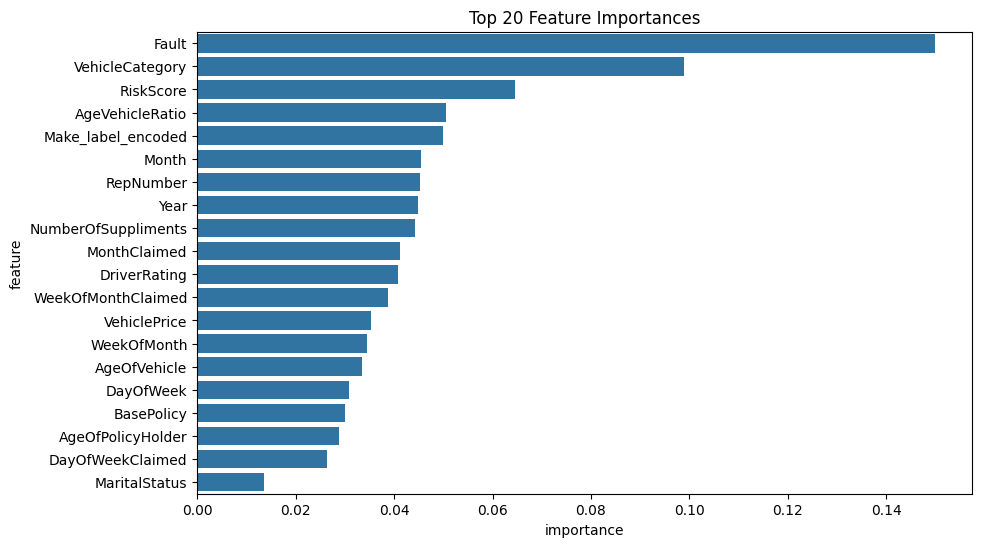

In [29]:
importances = best_rf.named_steps['rf'].feature_importances_
features = X_train.columns
feat_importance_df = pd.DataFrame({'feature': features, 'importance': importances})
feat_importance_df = feat_importance_df.sort_values(by='importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x='importance', y='feature', data=feat_importance_df.head(20))
plt.title("Top 20 Feature Importances")
plt.show()